## Neste documento, adicionaremos a tag legal/ilegal nos dados
- Importação dos dados
- Divisão por grupo de tipo de licitação
- Criação do algorítmo de classificação
- Implementação nas bases divididas por modalidade de licitação

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%time
path = r'C:\licitacoes_2019'
filenames = glob.glob(path + "/*.csv")

li= []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0, decimal=',',sep=';',encoding='latin1')
    li.append(df)

df_lic_2019 = pd.concat(li, axis=0, ignore_index=True)

Wall time: 0 ns


In [3]:
pd.options.display.max_colwidth = 1000

In [4]:
df_lic_2019.head(1)

,Número Licitação,Código UG,Nome UG,Código Modalidade Compra,Modalidade Compra,Número Processo,Objeto,Situação Licitação,Código Órgão Superior,Nome Órgão Superior,Código Órgão,Nome Órgão,Município,Data Resultado Compra,Data Abertura,Valor Licitação
0,12017,160501,MUSEU HISTORICO DO EXERCITO FORTE COPACABANA,2,Tomada de Preços,64615003280201719,Objeto: Obra de restauração da rede de esgoto do Museu Histórico do Exército e Forte de Copacabana.,Evento de Resultado de Julgame,52000,Ministério da Defesa,52121,Comando do Exército,RIO DE JANEIRO,17/01/2019,NaN,564266.95


In [5]:
df_lic_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169396 entries, 0 to 169395
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          169396 non-null  int64  
 1   Código UG                 169396 non-null  int64  
 2   Nome UG                   169396 non-null  object 
 3   Código Modalidade Compra  169396 non-null  int64  
 4   Modalidade Compra         169396 non-null  object 
 5   Número Processo           169390 non-null  object 
 6   Objeto                    169392 non-null  object 
 7   Situação Licitação        169396 non-null  object 
 8   Código Órgão Superior     169396 non-null  int64  
 9   Nome Órgão Superior       169396 non-null  object 
 10  Código Órgão              169396 non-null  int64  
 11  Nome Órgão                169396 non-null  object 
 12  Município                 169396 non-null  object 
 13  Data Resultado Compra     169396 non-null  o

In [6]:
df_lic_2019.shape

(169396, 16)

In [7]:
df_lic_2019.rename(columns={"Valor Licitação": "Total"},inplace=True)

In [8]:
df_lic_2019['Modalidade Compra'].value_counts()

Dispensa de Licitação               111021
Inexigibilidade de Licitação         21538
Pregão - Registro de Preço           19894
Pregão                               15963
Tomada de Preços                       624
Concorrência                           186
Convite                                145
Concurso                                17
Concorrência - Registro de Preço         5
Concorrência Internacional               3
Name: Modalidade Compra, dtype: int64

## É Obra ?

In [9]:
df_lic_2019['Obras'] = df_lic_2019['Objeto'].str.contains("OBRAS|OBRA|obras|obra|ENGENHARIA|engenharia|CONSTRU-CAO|constru-cao", na=False)

In [10]:
df_lic_2019['Obras'].value_counts()

False    164656
True       4740
Name: Obras, dtype: int64

In [11]:
df_lic_2019['Tipo'] = 1

In [12]:
df_lic_2019.loc[df_lic_2019['Obras'] == True, 'Tipo'] = 'Obras'
df_lic_2019.loc[df_lic_2019['Obras'] == False, 'Tipo'] = 'Compras/Servicos'

In [13]:
df_lic_2019['Tipo'].value_counts()

Compras/Servicos    164656
Obras                 4740
Name: Tipo, dtype: int64

In [14]:
#Excluindo o atributo Obras que não será utilizado nas análises posteriores.
df_lic_2019.drop(columns=['Obras'], axis=1, inplace=True)

In [15]:
df_lic_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169396 entries, 0 to 169395
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          169396 non-null  int64  
 1   Código UG                 169396 non-null  int64  
 2   Nome UG                   169396 non-null  object 
 3   Código Modalidade Compra  169396 non-null  int64  
 4   Modalidade Compra         169396 non-null  object 
 5   Número Processo           169390 non-null  object 
 6   Objeto                    169392 non-null  object 
 7   Situação Licitação        169396 non-null  object 
 8   Código Órgão Superior     169396 non-null  int64  
 9   Nome Órgão Superior       169396 non-null  object 
 10  Código Órgão              169396 non-null  int64  
 11  Nome Órgão                169396 non-null  object 
 12  Município                 169396 non-null  object 
 13  Data Resultado Compra     169396 non-null  o

# Separando as Licitações por Modalidade de Compra e aplicando as regras de acordo com os valores a partir do Decreto n. 9.412, de 18 de Junho de 2019.

## Registro de Preço/ Concorrência/Concorrência - Registro de Preço

In [16]:
df_lic_2019_RP = df_lic_2019[(df_lic_2019['Modalidade Compra']  == 'Pregão - Registro de Preço') | (df_lic_2019['Modalidade Compra'] == 'Concorrência - Registro de Preço') | (df_lic_2019['Modalidade Compra'] == 'Concorrência')]

In [17]:
df_lic_2019_RP['Modalidade Compra'].value_counts()

Pregão - Registro de Preço          19894
Concorrência                          186
Concorrência - Registro de Preço        5
Name: Modalidade Compra, dtype: int64

In [18]:
df_lic_2019_RP['Tipo'].value_counts()

Compras/Servicos    19572
Obras                 513
Name: Tipo, dtype: int64

In [19]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_RP_2019 = df_lic_2019_RP[df_lic_2019_RP['Tipo'] == 'Obras']
lic_compras_RP_2019 = df_lic_2019_RP[df_lic_2019_RP['Tipo'] != 'Obras']

## Tag'ando como legal ou ilegal de acordo  com Decreto nº 9.412, de 18 de Junho de 2019

#### 0: ilegal
#### 1: legal

In [20]:
lic_obras_RP_2019['Tag'] = 0
lic_compras_RP_2019['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/279326536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_RP_2019['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/279326536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_RP_2019['Tag'] = 0


In [21]:
#regra de limite de valor
#Considerando REGISTRO DE PREÇO como CONCORRENCIA e CONCORRENCIA - REGISTRO DE PREÇO
lic_obras_RP_2019.loc[lic_obras_RP_2019['Total'] > 3300000, 'Tag'] = 1
lic_compras_RP_2019.loc[lic_compras_RP_2019['Total'] > 1430000, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [22]:
lic_obras_RP_2019['Tag'].value_counts()

0    455
1     58
Name: Tag, dtype: int64

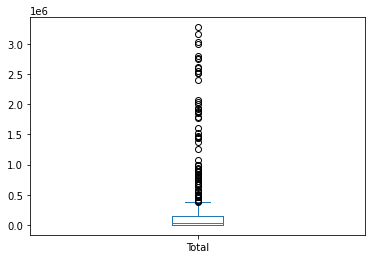

In [23]:
# Análise visual das licitações Ilegais para esta modalidade
lic_obras_RP_2019[lic_obras_RP_2019['Tag'] == 0]['Total'].plot.box()
plt.show()

In [24]:
lic_obras_RP_2019[lic_obras_RP_2019['Tag'] == 0]['Total'].describe()

count    4.550000e+02
mean     2.522252e+05
std      5.814601e+05
min      0.000000e+00
25%      3.649000e+03
50%      2.800000e+04
75%      1.552992e+05
max      3.272064e+06
Name: Total, dtype: float64

<AxesSubplot:>

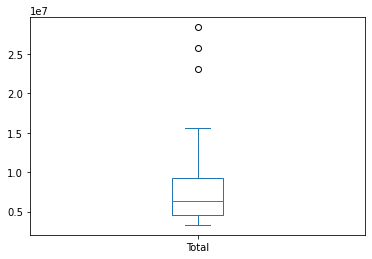

In [25]:
lic_obras_RP_2019[lic_obras_RP_2019['Tag'] == 1]['Total'].plot.box()

In [26]:
lic_compras_RP_2019['Tag'].value_counts()

0    19144
1      428
Name: Tag, dtype: int64

<AxesSubplot:>

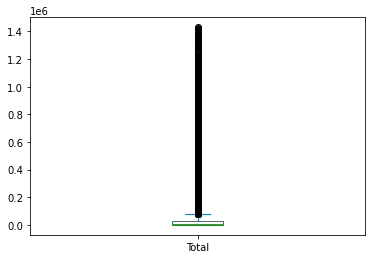

In [27]:
# Visualizando as licitações do tipo Registro de Preço que foram Ilegais
lic_compras_RP_2019[lic_compras_RP_2019['Tag'] == 0]['Total'].plot.box()

In [28]:
lic_compras_RP_2019[lic_compras_RP_2019['Tag'] == 0]['Total'].describe()

count    1.914400e+04
mean     5.362206e+04
std      1.543893e+05
min      0.000000e+00
25%      3.258325e+02
50%      4.847330e+03
75%      3.060000e+04
max      1.430000e+06
Name: Total, dtype: float64

<AxesSubplot:>

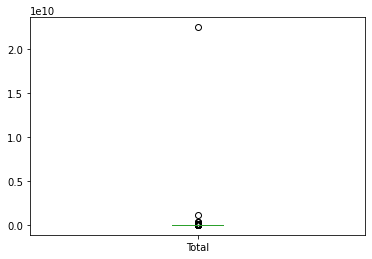

In [29]:
# Visualizando as licitações do tipo Registro de Preço que foram Legais
lic_compras_RP_2019[lic_compras_RP_2019['Tag'] == 1]['Total'].plot.box()

In [30]:
lic_compras_RP_2019[lic_compras_RP_2019['Tag'] == 1]['Total'].describe()

count    4.280000e+02
mean     6.531219e+07
std      1.088769e+09
min      1.433604e+06
25%      2.210588e+06
50%      3.742204e+06
75%      8.030066e+06
max      2.250000e+10
Name: Total, dtype: float64

## Dispensa de Licitação

In [31]:
df_lic_2019_Dispensa = df_lic_2019[df_lic_2019['Modalidade Compra'] == 'Dispensa de Licitação']

In [32]:
df_lic_2019_Dispensa['Modalidade Compra'].value_counts()

Dispensa de Licitação    111021
Name: Modalidade Compra, dtype: int64

In [33]:
df_lic_2019_Dispensa['Tipo'].value_counts()

Compras/Servicos    108960
Obras                 2061
Name: Tipo, dtype: int64

In [34]:
lic_obras_Dispensa_2019 = df_lic_2019_Dispensa[df_lic_2019_Dispensa['Tipo'] == 'Obras']
lic_compras_Dispensa_2019 = df_lic_2019_Dispensa[df_lic_2019_Dispensa['Tipo'] != 'Obras']

In [35]:
lic_obras_Dispensa_2019['Tipo'].value_counts()

Obras    2061
Name: Tipo, dtype: int64

In [36]:
lic_compras_Dispensa_2019['Tipo'].value_counts()

Compras/Servicos    108960
Name: Tipo, dtype: int64

## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2019

#### 0: ilegal
#### 1: legal

In [37]:
lic_obras_Dispensa_2019['Tag'] = 0
lic_compras_Dispensa_2019['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/3261363645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Dispensa_2019['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/3261363645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Dispensa_2019['Tag'] = 0


In [38]:
#regra de limite de valor
lic_obras_Dispensa_2019.loc[lic_obras_Dispensa_2019['Total'] <= 33000 , 'Tag'] = 1
lic_compras_Dispensa_2019.loc[lic_compras_Dispensa_2019['Total'] <= 17600, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [39]:
lic_obras_Dispensa_2019['Tag'].value_counts()

1    1797
0     264
Name: Tag, dtype: int64

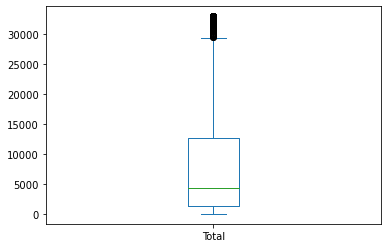

In [40]:
lic_obras_Dispensa_2019[lic_obras_Dispensa_2019['Tag'] == 1]['Total'].plot.box()
plt.show()

In [41]:
lic_obras_Dispensa_2019[lic_obras_Dispensa_2019['Tag'] == 1]['Total'].describe()

count     1797.000000
mean      7977.030223
std       8694.307743
min          1.000000
25%       1385.500000
50%       4324.000000
75%      12613.140000
max      33000.000000
Name: Total, dtype: float64

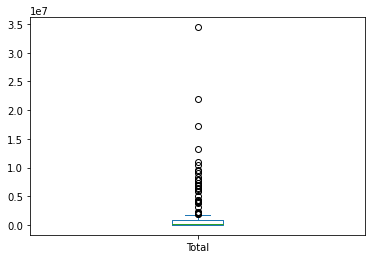

In [42]:
lic_obras_Dispensa_2019[lic_obras_Dispensa_2019['Tag'] == 0]['Total'].plot.box()
plt.show()

In [43]:
lic_obras_Dispensa_2019[lic_obras_Dispensa_2019['Tag'] == 0]['Total'].describe()

count    2.640000e+02
mean     1.351722e+06
std      3.387311e+06
min      3.571234e+04
25%      8.745128e+04
50%      2.742784e+05
75%      8.077608e+05
max      3.442936e+07
Name: Total, dtype: float64

In [44]:
lic_compras_Dispensa_2019['Tag'].value_counts()

1    102074
0      6886
Name: Tag, dtype: int64

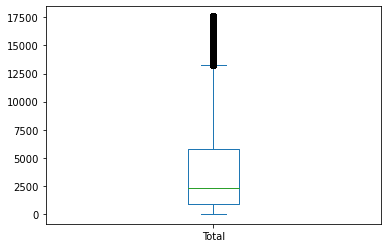

In [45]:
lic_compras_Dispensa_2019[lic_compras_Dispensa_2019['Tag'] == 1]['Total'].plot.box()
plt.show()

In [46]:
lic_compras_Dispensa_2019[lic_compras_Dispensa_2019['Tag'] == 1]['Total'].describe()

count    102074.000000
mean       4123.038055
std        4500.305806
min           0.000000
25%         856.000000
50%        2290.000000
75%        5819.825000
max       17600.000000
Name: Total, dtype: float64

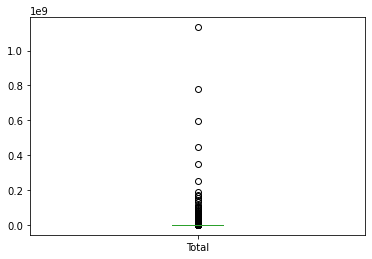

In [47]:
lic_compras_Dispensa_2019[lic_compras_Dispensa_2019['Tag'] == 0]['Total'].plot.box()
plt.show()

In [48]:
lic_compras_Dispensa_2019[lic_compras_Dispensa_2019['Tag'] == 0]['Total'].describe()

count    6.886000e+03
mean     1.568725e+06
std      2.071970e+07
min      1.760200e+04
25%      3.044706e+04
50%      6.952000e+04
75%      3.367689e+05
max      1.134000e+09
Name: Total, dtype: float64

## Tomada de Preço

In [49]:
df_lic_2019_tomada_de_preco = df_lic_2019[df_lic_2019['Modalidade Compra'] == 'Tomada de Preços']

In [50]:
df_lic_2019_tomada_de_preco['Modalidade Compra'].value_counts()

Tomada de Preços    624
Name: Modalidade Compra, dtype: int64

In [51]:
df_lic_2019_tomada_de_preco['Tipo'].value_counts()

Compras/Servicos    417
Obras               207
Name: Tipo, dtype: int64

In [52]:
lic_obras_tomada_de_preco_2019 = df_lic_2019_tomada_de_preco[df_lic_2019_tomada_de_preco['Tipo'] == 'Obras']
lic_compras_tomada_de_preco_2019 = df_lic_2019_tomada_de_preco[df_lic_2019_tomada_de_preco['Tipo'] != 'Obras']

In [53]:
lic_obras_tomada_de_preco_2019['Tipo'].value_counts()

Obras    207
Name: Tipo, dtype: int64

In [54]:
lic_compras_tomada_de_preco_2019['Tipo'].value_counts()

Compras/Servicos    417
Name: Tipo, dtype: int64

In [55]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2019

#### 0: ilegal
#### 1: legal

lic_obras_tomada_de_preco_2019['Tag'] = 0
lic_compras_tomada_de_preco_2019['Tag'] = 0

#regra de limite de valor
lic_obras_tomada_de_preco_2019.loc[(lic_obras_tomada_de_preco_2019['Total'] >  330000) & (lic_obras_tomada_de_preco_2019['Total'] <=   3300000) , 'Tag'] = 1
lic_compras_tomada_de_preco_2019.loc[(lic_compras_tomada_de_preco_2019['Total'] >  176000) & (lic_compras_tomada_de_preco_2019['Total'] <=  1400000), 'Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/1560496682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_tomada_de_preco_2019['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/1560496682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_tomada_de_preco_2019['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [56]:
lic_obras_tomada_de_preco_2019['Tag'].value_counts()

1    116
0     91
Name: Tag, dtype: int64

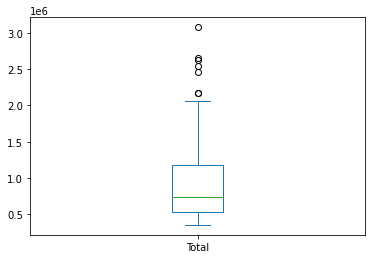

In [57]:
lic_obras_tomada_de_preco_2019[lic_obras_tomada_de_preco_2019['Tag'] == 1]['Total'].plot.box()
plt.show()

In [58]:
lic_obras_tomada_de_preco_2019[lic_obras_tomada_de_preco_2019['Tag'] == 1]['Total'].describe()

count    1.160000e+02
mean     9.261138e+05
std      5.825803e+05
min      3.524821e+05
25%      5.287377e+05
50%      7.306693e+05
75%      1.172320e+06
max      3.078745e+06
Name: Total, dtype: float64

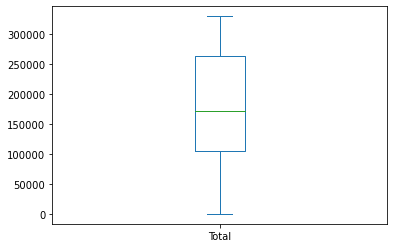

In [59]:
lic_obras_tomada_de_preco_2019[lic_obras_tomada_de_preco_2019['Tag'] == 0]['Total'].plot.box()
plt.show()

In [60]:
lic_compras_tomada_de_preco_2019['Tag'].value_counts()

1    264
0    153
Name: Tag, dtype: int64

In [61]:
# Licitaçoes Legais
lic_compras_tomada_de_preco_2019[lic_compras_tomada_de_preco_2019['Tag'] == 1]['Total'].describe()

count    2.640000e+02
mean     5.286806e+05
std      3.077656e+05
min      1.781517e+05
25%      2.819303e+05
50%      4.434251e+05
75%      6.938468e+05
max      1.387719e+06
Name: Total, dtype: float64

In [62]:
lic_compras_tomada_de_preco_2019[lic_compras_tomada_de_preco_2019['Tag'] == 1]['Total'].describe()

count    2.640000e+02
mean     5.286806e+05
std      3.077656e+05
min      1.781517e+05
25%      2.819303e+05
50%      4.434251e+05
75%      6.938468e+05
max      1.387719e+06
Name: Total, dtype: float64

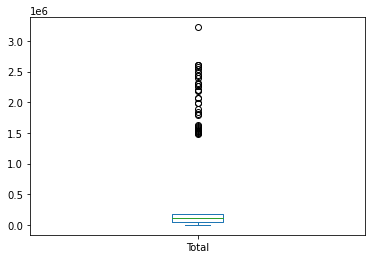

In [63]:
# Licitações Ilegais
lic_compras_tomada_de_preco_2019[lic_compras_tomada_de_preco_2019['Tag'] == 0]['Total'].plot.box()
plt.show()

In [64]:
lic_compras_tomada_de_preco_2019[lic_compras_tomada_de_preco_2019['Tag'] == 0]['Total'].describe()

count    1.530000e+02
mean     5.567642e+05
std      8.712525e+05
min      0.000000e+00
25%      5.178062e+04
50%      1.057411e+05
75%      1.740058e+05
max      3.222674e+06
Name: Total, dtype: float64

## Convite

In [65]:
df_lic_2019_convite = df_lic_2019[df_lic_2019['Modalidade Compra'] == 'Convite']

In [66]:
df_lic_2019_convite['Modalidade Compra'].value_counts()

Convite    145
Name: Modalidade Compra, dtype: int64

In [67]:
df_lic_2019_convite['Tipo'].value_counts()

Compras/Servicos    81
Obras               64
Name: Tipo, dtype: int64

In [68]:
lic_compras_convite_2019 = df_lic_2019_convite[df_lic_2019_convite['Tipo'] != 'Obras']
lic_obras_convite_2019 = df_lic_2019_convite[df_lic_2019_convite['Tipo'] == 'Obras']

In [69]:
lic_compras_convite_2019['Tipo'].value_counts()

Compras/Servicos    81
Name: Tipo, dtype: int64

In [70]:
lic_obras_convite_2019['Tipo'].value_counts()

Obras    64
Name: Tipo, dtype: int64

In [71]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2019

#### 0: ilegal
#### 1: legal

lic_compras_convite_2019['Tag'] = 0
lic_obras_convite_2019['Tag'] = 0

#regra de limite de valor
lic_compras_convite_2019.loc[(lic_compras_convite_2019['Total'] >  17600) & (lic_compras_convite_2019['Total'] <=   176000) , 'Tag'] = 1
lic_obras_convite_2019.loc[(lic_obras_convite_2019['Total'] >  33000) & (lic_obras_convite_2019['Total'] <=   330000), 'Tag'] = 1


C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/1789816130.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_convite_2019['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/1789816130.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_convite_2019['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [72]:
lic_compras_convite_2019['Tag'].value_counts()

1    57
0    24
Name: Tag, dtype: int64

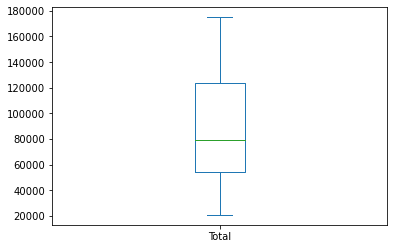

In [73]:
lic_compras_convite_2019[lic_compras_convite_2019['Tag'] == 1]['Total'].plot.box()
plt.show()

In [74]:
lic_compras_convite_2019[lic_compras_convite_2019['Tag'] == 1]['Total'].describe()

count        57.000000
mean      86998.272281
std       43456.338554
min       20879.040000
25%       54432.000000
50%       79385.040000
75%      123815.550000
max      175000.000000
Name: Total, dtype: float64

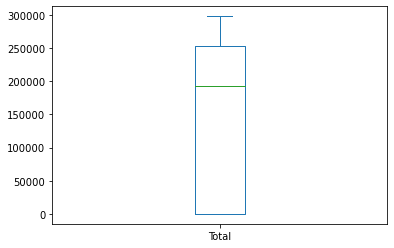

In [75]:
lic_compras_convite_2019[lic_compras_convite_2019['Tag'] == 0]['Total'].plot.box()
plt.show()

In [76]:
lic_compras_convite_2019[lic_compras_convite_2019['Tag'] == 0]['Total'].describe()

count        24.000000
mean     140056.008333
std      120815.284198
min           0.000000
25%           0.000000
50%      192299.125000
75%      253530.710000
max      297884.880000
Name: Total, dtype: float64

In [77]:
lic_obras_convite_2019['Tag'].value_counts()

1    57
0     7
Name: Tag, dtype: int64

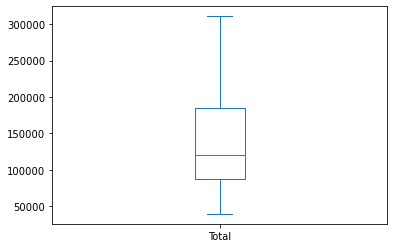

In [78]:
lic_obras_convite_2019[lic_obras_convite_2019['Tag'] == 1]['Total'].plot.box()
plt.show()

In [79]:
lic_obras_convite_2019[lic_obras_convite_2019['Tag'] == 1]['Total'].describe()

count        57.000000
mean     137386.037368
std       67580.145751
min       39471.600000
25%       87679.260000
50%      119961.320000
75%      185384.260000
max      310956.240000
Name: Total, dtype: float64

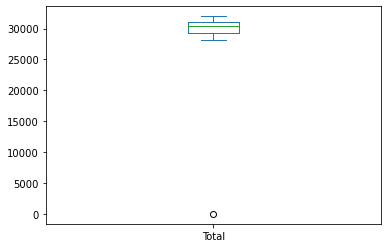

In [80]:
lic_obras_convite_2019[lic_obras_convite_2019['Tag'] == 0]['Total'].plot.box()
plt.show()

In [81]:
lic_obras_convite_2019[lic_obras_convite_2019['Tag'] == 0]['Total'].describe()

count        7.000000
mean     26169.190000
std      11606.516075
min          0.000000
25%      29271.935000
50%      30411.560000
75%      31113.500000
max      32001.900000
Name: Total, dtype: float64

### As modalidades abaixo não possuem uma regra bem definida para os valores de Licitação. Dessa forma, será atribuido a tag legal como padrão.

## Pregão

In [82]:
df_lic_2019_Pregao = df_lic_2019[df_lic_2019['Modalidade Compra'] == 'Pregão']

In [83]:
df_lic_2019_Pregao['Modalidade Compra'].value_counts()

Pregão    15963
Name: Modalidade Compra, dtype: int64

In [84]:
df_lic_2019_Pregao['Tipo'].value_counts()

Compras/Servicos    14443
Obras                1520
Name: Tipo, dtype: int64

In [85]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Pregao_2019 = df_lic_2019_Pregao[df_lic_2019_Pregao['Tipo'] == 'Obras']
lic_compras_Pregao_2019 = df_lic_2019_Pregao[df_lic_2019_Pregao['Tipo'] != 'Obras']

In [86]:
lic_obras_Pregao_2019['Tipo'].value_counts()

Obras    1520
Name: Tipo, dtype: int64

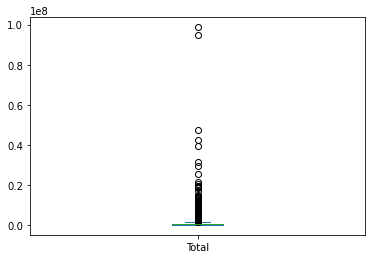

In [87]:
lic_obras_Pregao_2019['Total'].plot.box()
plt.show()

In [88]:
lic_obras_Pregao_2019['Total'].describe()

count    1.520000e+03
mean     1.223781e+06
std      4.751897e+06
min      0.000000e+00
25%      5.594957e+04
50%      2.086996e+05
75%      7.045492e+05
max      9.870000e+07
Name: Total, dtype: float64

In [89]:
lic_compras_Pregao_2019['Tipo'].value_counts()

Compras/Servicos    14443
Name: Tipo, dtype: int64

<AxesSubplot:>

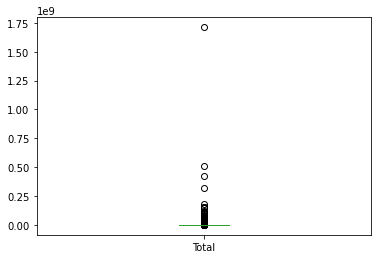

In [90]:
lic_compras_Pregao_2019['Total'].plot.box()

In [91]:
lic_compras_Pregao_2019['Total'].describe()

count    1.444300e+04
mean     1.009878e+06
std      1.623632e+07
min      0.000000e+00
25%      1.449976e+04
50%      6.249400e+04
75%      2.560000e+05
max      1.711541e+09
Name: Total, dtype: float64

In [92]:
## Tag'ando como legal já que não existe uma regra bem definida para a modalidade Pregão

#### 0: ilegal
#### 1: legal
lic_obras_Pregao_2019['Tag'] = 1
lic_compras_Pregao_2019['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/2361053330.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Pregao_2019['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/2361053330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Pregao_2019['Tag'] = 1


In [93]:
lic_obras_Pregao_2019['Tag'].value_counts()

1    1520
Name: Tag, dtype: int64

In [94]:
lic_compras_Pregao_2019['Tag'].value_counts()

1    14443
Name: Tag, dtype: int64

## Inexigibilidade de Licitação 

In [95]:
df_lic_2019_Inex_2019 = df_lic_2019[df_lic_2019['Modalidade Compra'] == 'Inexigibilidade de Licitação']

In [96]:
df_lic_2019_Inex_2019['Modalidade Compra'].value_counts()

Inexigibilidade de Licitação    21538
Name: Modalidade Compra, dtype: int64

In [97]:
df_lic_2019_Inex_2019['Tipo'].value_counts()

Compras/Servicos    21166
Obras                 372
Name: Tipo, dtype: int64

In [98]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Inex_2019 = df_lic_2019_Inex_2019[df_lic_2019_Inex_2019['Tipo'] == 'Obras']
lic_compras_Inex_2019 = df_lic_2019_Inex_2019[df_lic_2019_Inex_2019['Tipo'] != 'Obras']

In [99]:
lic_obras_Inex_2019['Tipo'].value_counts()

Obras    372
Name: Tipo, dtype: int64

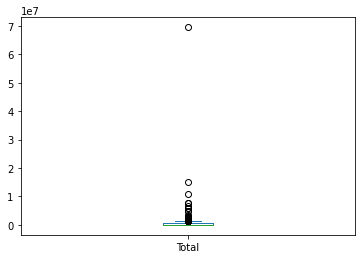

In [100]:
lic_obras_Inex_2019['Total'].plot.box()
plt.show()

In [101]:
lic_obras_Inex_2019['Total'].describe()

count    3.720000e+02
mean     6.894279e+05
std      3.831799e+06
min      1.000000e-02
25%      3.290000e+03
50%      1.263000e+04
75%      5.226578e+05
max      6.949661e+07
Name: Total, dtype: float64

In [102]:
lic_compras_Inex_2019['Tipo'].value_counts()

Compras/Servicos    21166
Name: Tipo, dtype: int64

<AxesSubplot:>

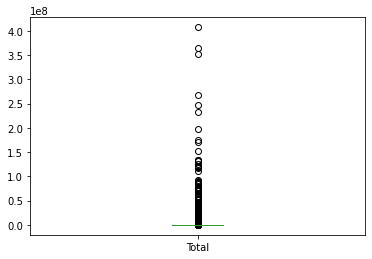

In [103]:
lic_compras_Inex_2019['Total'].plot.box()

In [104]:
lic_compras_Inex_2019['Total'].describe()

count    2.116600e+04
mean     5.754203e+05
std      7.295838e+06
min      1.000000e-02
25%      1.822015e+03
50%      5.990000e+03
75%      3.000000e+04
max      4.074005e+08
Name: Total, dtype: float64

In [105]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_Inex_2019['Tag'] = 1
lic_compras_Inex_2019['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/508744298.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Inex_2019['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/508744298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Inex_2019['Tag'] = 1


In [106]:
lic_obras_Inex_2019['Tag'].value_counts()

1    372
Name: Tag, dtype: int64

In [107]:
lic_compras_Inex_2019['Tag'].value_counts()

1    21166
Name: Tag, dtype: int64

## Concurso

In [108]:
df_lic_2019_concurso = df_lic_2019[df_lic_2019['Modalidade Compra'] == 'Concurso']

In [109]:
df_lic_2019_concurso['Modalidade Compra'].value_counts()

Concurso    17
Name: Modalidade Compra, dtype: int64

In [110]:
df_lic_2019_concurso['Tipo'].value_counts()

Compras/Servicos    14
Obras                3
Name: Tipo, dtype: int64

In [111]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concurso_2019 = df_lic_2019_concurso[df_lic_2019_concurso['Tipo'] == 'Obras']
lic_compras_concurso_2019 = df_lic_2019_concurso[df_lic_2019_concurso['Tipo'] != 'Obras']

In [112]:
lic_obras_concurso_2019['Tipo'].value_counts()

Obras    3
Name: Tipo, dtype: int64

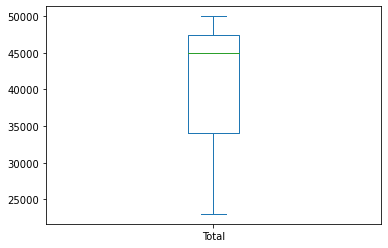

In [113]:
lic_obras_concurso_2019['Total'].plot.box()
plt.show()

<AxesSubplot:>

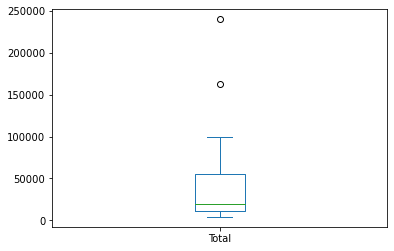

In [114]:
lic_compras_concurso_2019['Total'].plot.box()

In [115]:
lic_compras_concurso_2019['Total'].describe()

count        14.000000
mean      52000.000000
std       70220.487915
min        4000.000000
25%       10875.000000
50%       18950.000000
75%       55500.000000
max      240000.000000
Name: Total, dtype: float64

In [116]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concurso_2019['Tag'] = 1
lic_compras_concurso_2019['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/337068040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_concurso_2019['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_11512/337068040.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_concurso_2019['Tag'] = 1


In [117]:
lic_obras_concurso_2019['Tag'].value_counts()

1    3
Name: Tag, dtype: int64

In [118]:
lic_compras_concurso_2019['Tag'].value_counts()

1    14
Name: Tag, dtype: int64

### Concorrência Internacional

In [119]:
df_lic_2019_concorrencia_internacional = df_lic_2019[df_lic_2019['Modalidade Compra'] == 'Concorrência Internacional']

In [120]:
df_lic_2019_concorrencia_internacional['Modalidade Compra'].value_counts()

Concorrência Internacional    3
Name: Modalidade Compra, dtype: int64

In [121]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concorrencia_internacional_2019 = df_lic_2019_concorrencia_internacional[df_lic_2019_concorrencia_internacional['Tipo'] == 'Obras']
lic_compras_concorrencia_internacional_2019 = df_lic_2019_concorrencia_internacional[df_lic_2019_concorrencia_internacional['Tipo'] != 'Obras']

In [122]:
lic_obras_concorrencia_internacional_2019['Tipo'].value_counts()

Series([], Name: Tipo, dtype: int64)

In [123]:
lic_compras_concorrencia_internacional_2019['Tipo'].value_counts()

Compras/Servicos    3
Name: Tipo, dtype: int64

<AxesSubplot:>

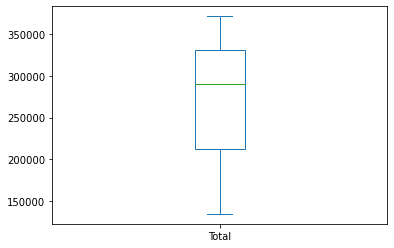

In [124]:
lic_compras_concorrencia_internacional_2019['Total'].plot.box()

In [125]:
lic_compras_concorrencia_internacional_2019['Total'].describe()

count         3.000000
mean     265434.636667
std      120327.502071
min      134640.000000
25%      212436.470000
50%      290232.940000
75%      330831.955000
max      371430.970000
Name: Total, dtype: float64

In [126]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concorrencia_internacional_2019['Tag'] = 1
lic_compras_concorrencia_internacional_2019['Tag'] = 1

In [127]:
lic_obras_concorrencia_internacional_2019['Tag'].value_counts()

Series([], Name: Tag, dtype: int64)

In [128]:
lic_compras_concorrencia_internacional_2019['Tag'].value_counts()

1    3
Name: Tag, dtype: int64

### Salvando todas as analises em uma única base de dados.

In [129]:
lic_2019_com_tag = pd.concat([lic_obras_RP_2019, lic_compras_RP_2019, lic_obras_Dispensa_2019, lic_compras_Dispensa_2019, lic_obras_tomada_de_preco_2019, lic_compras_tomada_de_preco_2019, lic_compras_convite_2019, lic_obras_convite_2019, lic_obras_Pregao_2019, lic_compras_Pregao_2019, lic_obras_Inex_2019, lic_compras_Inex_2019, lic_obras_concurso_2019, lic_compras_concurso_2019, lic_obras_concorrencia_internacional_2019, lic_compras_concorrencia_internacional_2019])

In [130]:
lic_2019_com_tag.to_csv('lic_2019_com_tag.csv')

In [131]:
lic_2019_com_tag['Tag'].value_counts()

1    142372
0     27024
Name: Tag, dtype: int64

In [132]:
lic_2019_com_tag.groupby(['Modalidade Compra','Tag', 'Tipo']).describe()

Número Licitação  \
                                                                 count   
Modalidade Compra                Tag Tipo                                
Concorrência                     0   Compras/Servicos             55.0   
                                     Obras                        26.0   
                                 1   Compras/Servicos             65.0   
                                     Obras                        40.0   
Concorrência - Registro de Preço 0   Compras/Servicos              4.0   
                                     Obras                         1.0   
Concorrência Internacional       1   Compras/Servicos              3.0   
Concurso                         1   Compras/Servicos             14.0   
                                     Obras                         3.0   
Convite                          0   Compras/Servicos             24.0   
                                     Obras                         7.0   
                                 1   Compras/Servicos             57.0   
                                     Obras                        57.0   
Dispensa de Licitação            0   Compras/Servicos           6886.0   
                                     Obras                       264.0   
                                 1   Compras/Servicos         102074.0   
                                     Obras                      1797.0   
Inexigibilidade de Licitação     1   Compras/Servicos          21166.0   
                                     Obras                       372.0   
Pregão                           1   Compras/Servicos          14443.0   
                                     Obras                      1520.0   
Pregão - Registro de Preço       0   Compras/Servicos          19085.0   
                                     Obras                       428.0   
                                 1   Compras/Servicos            363.0   
                                     Obras                        18.0   
Tomada de Preços                 0   Compras/Servicos            153.0   
                                     Obras                        91.0   
                                 1   Compras/Servicos            264.0   
                                     Obras                       116.0   

                                                                     \
                                                               mean   
Modalidade Compra                Tag Tipo                             
Concorrência                     0   Compras/Servicos  1.278367e+05   
                                     Obras             4.663408e+04   
                                 1   Compras/Servicos  1.003262e+05   
                                     Obras             1.642686e+05   
Concorrência - Registro de Preço 0   Compras/Servicos  2.951900e+04   
                                     Obras             1.020180e+05   
Concorrência Internacional       1   Compras/Servicos  3.535200e+04   
Concurso                         1   Compras/Servicos  2.773314e+04   
                                     Obras             2.535133e+04   
Convite                          0   Compras/Servicos  2.566022e+05   
                                     Obras             2.630457e+04   
                                 1   Compras/Servicos  2.592117e+05   
                                     Obras             4.956261e+04   
Dispensa de Licitação            0   Compras/Servicos  1.710900e+07   
                                     Obras             7.102246e+06   
                                 1   Compras/Servicos  1.576805e+07   
                                     Obras             6.675803e+06   
Inexigibilidade de Licitação     1   Compras/Servicos  1.334088e+07   
                                     Obras             4.156696e+06   
Pregão                           1   Compras/Servicos  7.671944e+06   
                                     Obras          

In [133]:
import numpy as np
%matplotlib inline

In [134]:
lic_2019_com_tag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169396 entries, 12 to 152726
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Número Licitação          169396 non-null  int64  
 1   Código UG                 169396 non-null  int64  
 2   Nome UG                   169396 non-null  object 
 3   Código Modalidade Compra  169396 non-null  int64  
 4   Modalidade Compra         169396 non-null  object 
 5   Número Processo           169390 non-null  object 
 6   Objeto                    169392 non-null  object 
 7   Situação Licitação        169396 non-null  object 
 8   Código Órgão Superior     169396 non-null  int64  
 9   Nome Órgão Superior       169396 non-null  object 
 10  Código Órgão              169396 non-null  int64  
 11  Nome Órgão                169396 non-null  object 
 12  Município                 169396 non-null  object 
 13  Data Resultado Compra     169396 non-null  